In [2]:
import requests
import datetime
import pydantic
import pandas as pd
import plotly.express as px
import datetime

API_KEY = "xutthojn7xa28q6"

%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
pd.options.display.max_rows = 999

<IPython.core.display.Javascript object>

In [4]:
class ElexonRequest(pydantic.BaseModel):
    report: str
    date: datetime.date
    api_key: str = API_KEY
    service_type: str = "csv"

    @property
    def url(self):
        return f"https://api.bmreports.com/BMRS/{self.report}/v1?APIKey={self.api_key}&Period=*&SettlementDate={self.date.isoformat()}&ServiceType={self.service_type}"

<IPython.core.display.Javascript object>

In [5]:
req = ElexonRequest(report="B1770", date="2020-01-01")
str(req.api_key)

'xutthojn7xa28q6'

<IPython.core.display.Javascript object>

In [6]:
r = requests.get(req.url)
print(req.url)
print(r.text)

https://api.bmreports.com/BMRS/B1770/v1?APIKey=xutthojn7xa28q6&Period=*&SettlementDate=2020-01-01&ServiceType=csv
*
*
*Imbalance Prices Service For Balancing (B1770) Data
*
*DocumentID,DocumentRevNum,ActiveFlag,ProcessType,DocumentType,Resolution,CurveType,PriceCategory,ImbalancePriceAmount,SettlementPeriod,SettlementDate,ControlArea,BusinessType,TimeSeriesID,DocumentStatus
ELX-EMFIP-IMBP-22444358,1,Y,Realised,Imbalance prices,PT30M,Sequential fixed size block,Excess balance,49.95,48,2020-01-01,10YGB----------A,Balance energy deviation,ELX-EMFIP-IMBP-TS-2,Final
ELX-EMFIP-IMBP-22444358,1,Y,Realised,Imbalance prices,PT30M,Sequential fixed size block,Insufficient balance,49.95,48,2020-01-01,10YGB----------A,Balance energy deviation,ELX-EMFIP-IMBP-TS-1,Final
ELX-EMFIP-IMBP-22444205,1,Y,Realised,Imbalance prices,PT30M,Sequential fixed size block,Excess balance,50.05,47,2020-01-01,10YGB----------A,Balance energy deviation,ELX-EMFIP-IMBP-TS-2,Final
ELX-EMFIP-IMBP-22444205,1,Y,Realised,Imbalan

<IPython.core.display.Javascript object>

In [7]:
def get_sip_prices(start_date: str, period: int):
    sip_price_endpoint = f"""https://api.bmreports.com/BMRS/B1770/v1?APIKey={API_KEY}
    &SettlementDate={start_date}&Period={period}&ServiceType=csv"""

    response = requests.get(sip_price_endpoint)
    print(sip_price_endpoint)

    if response.status_code == 200:
        return response.json()

    raise Exception(response.content)

<IPython.core.display.Javascript object>

In [8]:
prices = get_sip_prices("2014-12-31", "1")

https://api.bmreports.com/BMRS/B1770/v1?APIKey=xutthojn7xa28q6
    &SettlementDate=2014-12-31&Period=1&ServiceType=csv


JSONDecodeError: [Errno Expecting value] <?xml version="1.0" encoding="UTF-8" standalone="yes"?><response><responseMetadata><httpCode>403</httpCode><errorType>forbidden</errorType><description>An invalid API key has been passed</description><queryString>SettlementDate=2014-12-31,Period=1</queryString></responseMetadata></response>: 0

<IPython.core.display.Javascript object>

In [68]:
from ElexonDataPortal import api

client = api.Client(API_KEY)

<IPython.core.display.Javascript object>

In [69]:
start_date = "2022-03-01"
end_date = "2022-04-01"


df_B1770 = client.get_B1770(start_date, end_date)

B1770:   1%|▏         | 22/1486 [00:07<08:45,  2.79it/s]


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [ ]:
df_B1770.head()

""


<IPython.core.display.Javascript object>

In [ ]:
px.line(df_B1770, x='a
')

# Read downloaded data instead
From https://www.elexonportal.co.uk/article/view/250?cachebust=l2sdds7gue

In [12]:
sip_df = pd.read_csv(
    "../data/sspsbpniv.csv",
    parse_dates=[0],
    date_parser=lambda x: pd.to_datetime(x, dayfirst=True),
)


# Source: https://adgefficiency.com/elexon-api-uk-electricity-grid-data-with-python/
sip_df["datetime"] = pd.date_range(
    start=sip_df["Settlement Date"].iloc[0],
    periods=len(sip_df),
    freq="30T",
    tz="Europe/London",
)

SSP_COL = "System Sell Price(£/MWh)"

<IPython.core.display.Javascript object>

In [13]:
sip_df.head()

assert (sip_df["Settlement Date"] == sip_df["datetime"].apply(lambda x: x.date)).all()

<IPython.core.display.Javascript object>

In [14]:
px.line(sip_df, x="datetime", y=SSP_COL)

<IPython.core.display.Javascript object>

In [15]:
min_price_idx = sip_df["System Sell Price(£/MWh)"].idxmin()
sip_df.loc[min_price_idx]

Settlement Date                    2022-03-19 00:00:00
Settlement Period                                   27
System Sell Price(£/MWh)                        -90.32
System Buy Price(£/MWh)                         -90.32
Net Imbalance Volume(MWh)                     -1194.79
datetime                     2022-03-19 13:00:00+00:00
Name: 51676, dtype: object

<IPython.core.display.Javascript object>

The lowest price was in March 2022

In [16]:
px.line(
    sip_df.loc[51500:52500],
    x="datetime",
    y=SSP_COL,
    hover_data=["Settlement Date", "Settlement Period"],
)

<IPython.core.display.Javascript object>

Which months have the most SP's with negative prices?

In [17]:
sip_df["month"] = sip_df["datetime"].apply(lambda x: x.month)
monthly_negative_prices = sip_df.groupby("month")[SSP_COL].apply(
    lambda x: 100 * (sum(x < 0) / len(x))
)

<IPython.core.display.Javascript object>

In [18]:
px.bar(monthly_negative_prices, title="% of periods with a negative price")

<IPython.core.display.Javascript object>

# What units were being curtailed then?

In [19]:
start_date = "2022-03-19 10:00"
end_date = "2022-03-19 14:00"

client.get_B1610(start_date, end_date)

NameError: name 'client' is not defined

<IPython.core.display.Javascript object>

In [20]:
df_generation = _

<IPython.core.display.Javascript object>

In [ ]:
df_generation["quantity"] = df_generation["quantity"].astype(float)

<IPython.core.display.Javascript object>

B1610 seems to give us total generation at any point in time: the quantities are never negative

In [ ]:
px.scatter(df_generation, x="marketGenerationBMUId", y="quantity")

<IPython.core.display.Javascript object>

In [ ]:
df_generation.iloc[0]

local_datetime                   2022-03-19 10:00:00+00:00
documentType                             Actual generation
businessType                                    Production
processType                                       Realised
timeSeriesID                        ELX-EMFIP-AGOG-TS-9548
curveType                      Sequential fixed size block
settlementDate                                  2022-03-19
powerSystemResourceType                         Generation
registeredResourceEICCode                 48W000000HINB-85
marketGenerationUnitEICCode               48W000000HINB-85
marketGenerationBMUId                             T_HINB-8
marketGenerationNGCBMUId                            HINB-8
bMUnitID                                          T_HINB-8
nGCBMUnitID                                         HINB-8
activeFlag                                               Y
documentID                         ELX-EMFIP-AGOG-28836303
documentRevNum                                          

<IPython.core.display.Javascript object>

# Bid offer pairs
Downloaded from https://www.bmreports.com/bmrs/?q=balancing/bidoffer

The [API guide](https://www.elexon.co.uk/documents/training-guidance/bsc-guidance-notes/bmrs-api-and-data-push-user-guide-2/) implies this is deprecated (5.2.2) but no idea what replaces it

In [23]:
df_bo = pd.read_csv("../data/BidOfferData_20220605_1122.csv")

<IPython.core.display.Javascript object>

In [24]:
df_bo = df_bo.reset_index()

<IPython.core.display.Javascript object>

In [25]:
df_bo

,level_0,level_1,level_2,level_3,level_4,HDR,BID OFFER LEVEL DATA,20220319,27
0,BOD,2__AANGE001,1.0,2.022032e+13,0.0,2.022032e+13,0.0,0.0,0.0
1,BOD,2__AANGE001,-1.0,2.022032e+13,0.0,2.022032e+13,0.0,0.0,0.0
2,BOD,2__AANGE002,1.0,2.022032e+13,0.0,2.022032e+13,0.0,8998.0,9999.0
3,BOD,2__AANGE002,-1.0,2.022032e+13,0.0,2.022032e+13,0.0,-9999.0,-8999.0
4,BOD,2__ABGAS000,1.0,2.022032e+13,0.0,2.022032e+13,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2558,BOD,V__NFLEX002,1.0,2.022032e+13,0.0,2.022032e+13,0.0,0.0,0.0
2559,BOD,V__NFLEX002,-1.0,2.022032e+13,0.0,2.022032e+13,0.0,0.0,0.0
2560,BOD,V__PFLEX001,1.0,2.022032e+13,0.0,2.022032e+13,0.0,9000.0,9999.0
2561,BOD,V__PFLEX001,-1.0,2.022032e+13,0.0,2.022032e+13,0.0,-9999.0,-9000.0


<IPython.core.display.Javascript object>

Actually I think we want Physical data (final physical notification)

From https://www.bmreports.com/bmrs/?q=balancing/physicaldata

In [28]:
df_fpn = pd.read_csv(
    "../data/PhysicalData_20220319_27.csv",
    skiprows=lambda x: x > 1541 or x == 0,
    names=[
        "Notification Type",
        "Unit ID",
        "Settlement Period",
        "From Time",
        "From Level",
        "To Time",
        "To Level",
    ],
    parse_dates=["From Time", "To Time"],
    date_parser=lambda x: pd.to_datetime(x, format="%Y%m%d%H%M%S"),
)  # This includes other kinds of data with different cols

<IPython.core.display.Javascript object>

In [29]:
df_fpn

,Notification Type,Unit ID,Settlement Period,From Time,From Level,To Time,To Level
0,PN,2__AANGE001,27,2022-03-19 13:00:00,0.0,2022-03-19 13:05:00,0.0
1,PN,2__AANGE001,27,2022-03-19 13:05:00,0.0,2022-03-19 13:10:00,0.0
2,PN,2__AANGE001,27,2022-03-19 13:10:00,0.0,2022-03-19 13:15:00,0.0
3,PN,2__AANGE001,27,2022-03-19 13:15:00,0.0,2022-03-19 13:30:00,0.0
4,PN,2__AANGE002,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0
...,...,...,...,...,...,...,...
1536,PN,V__MGAZP001,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0
1537,PN,V__NFLEX001,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0
1538,PN,V__NFLEX002,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0
1539,PN,V__PFLEX001,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0


<IPython.core.display.Javascript object>

Join in data on these units to figure out what they are

In [32]:
df_bm_units = pd.read_excel("../data/BMUFuelType.xls", header=0)
df_bm_units.head()

,NGC_BMU_ID,SETT_BMU_ID,FUEL TYPE,EFF_FROM,EFF_TO,Unnamed: 5,Comments,EELPS?
0,ABRBO-1,T_ABRBO-1,WIND,2017-08-29,NaN,NaN,NaN,NaN
1,ABRTW-1,E_ABRTW-1,WIND,2016-09-05,NaN,NaN,NaN,NaN
2,ACHLW-1,C__PSMAR001,WIND,2018-09-05,NaN,NaN,C__PSMAR001,NaN
3,ACHRW-1,T_ACHRW-1,WIND,2015-10-01,NaN,NaN,T_ACHRW-1,NaN
4,ACHYW-1,NaN,WIND,2010-06-07,NaN,NaN,NaN,EELPS


<IPython.core.display.Javascript object>

In [33]:
df_bm_units.head()
df_fpn = (
    df_fpn.set_index("Unit ID")
    .join(df_bm_units.set_index("SETT_BMU_ID")["FUEL TYPE"])
    .rename(columns={"FUEL TYPE": "Fuel Type"})
)

<IPython.core.display.Javascript object>

We don't seem to have many of the fuel types :( 

In [34]:
df_fpn["Fuel Type"].value_counts(dropna=False)

NaN        1181
WIND        200
CCGT         62
NPSHYD       22
OCGT         17
PS           17
NUCLEAR      14
BIOMASS      14
COAL         10
Wind          2
OTHER         2
Name: Fuel Type, dtype: int64

<IPython.core.display.Javascript object>

In [35]:
df_fpn[df_fpn["Fuel Type"] == "WIND"].head()

,Notification Type,Settlement Period,From Time,From Level,To Time,To Level,Fuel Type
2__PENEC001,PN,27,2022-03-19 13:00:00,38.0,2022-03-19 13:30:00,23.0,WIND
2__PSTAT001,PN,27,2022-03-19 13:00:00,41.0,2022-03-19 13:30:00,26.0,WIND
2__PSTAT002,PN,27,2022-03-19 13:00:00,38.0,2022-03-19 13:30:00,27.0,WIND
E_ABRTW-1,PN,27,2022-03-19 13:00:00,6.0,2022-03-19 13:30:00,7.0,WIND
E_AIRSW-1,PN,27,2022-03-19 13:00:00,4.0,2022-03-19 13:30:00,4.0,WIND


<IPython.core.display.Javascript object>

Evidence of wind curtailment

In [36]:
df_fpn.reset_index()

,index,Notification Type,Settlement Period,From Time,From Level,To Time,To Level,Fuel Type
0,2__AANGE001,PN,27,2022-03-19 13:00:00,0.0,2022-03-19 13:05:00,0.0,NaN
1,2__AANGE001,PN,27,2022-03-19 13:05:00,0.0,2022-03-19 13:10:00,0.0,NaN
2,2__AANGE001,PN,27,2022-03-19 13:10:00,0.0,2022-03-19 13:15:00,0.0,NaN
3,2__AANGE001,PN,27,2022-03-19 13:15:00,0.0,2022-03-19 13:30:00,0.0,NaN
4,2__AANGE001,QPN,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0,NaN
...,...,...,...,...,...,...,...,...
1536,V__MFLEX001,PN,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0,NaN
1537,V__MGAZP001,PN,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0,NaN
1538,V__NFLEX001,PN,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0,NaN
1539,V__NFLEX002,PN,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0,NaN


<IPython.core.display.Javascript object>

In [37]:
def convert_to_linear_type(df: pd.DataFrame):
    base_columns = ["Notification Type", "Settlement Period", "Fuel Type"]
    from_columns = ["From Level", "From Time"]
    to_columns = ["To Level", "To Time"]

    return pd.concat(
        (
            df[base_columns + from_columns].rename(
                columns={"From Level": "Level", "From Time": "Time"}
            ),
            df[base_columns + to_columns].rename(
                columns={"To Level": "Level", "To Time": "Time"}
            ),
        )
    )

<IPython.core.display.Javascript object>

In [38]:
df_fpn_linear = convert_to_linear_type(df_fpn)

<IPython.core.display.Javascript object>

In [39]:
df_fpn_linear

,Notification Type,Settlement Period,Fuel Type,Level,Time
2__AANGE001,PN,27,NaN,0.0,2022-03-19 13:00:00
2__AANGE001,PN,27,NaN,0.0,2022-03-19 13:05:00
2__AANGE001,PN,27,NaN,0.0,2022-03-19 13:10:00
2__AANGE001,PN,27,NaN,0.0,2022-03-19 13:15:00
2__AANGE001,QPN,27,NaN,0.0,2022-03-19 13:00:00
...,...,...,...,...,...
V__MFLEX001,PN,27,NaN,0.0,2022-03-19 13:30:00
V__MGAZP001,PN,27,NaN,0.0,2022-03-19 13:30:00
V__NFLEX001,PN,27,NaN,0.0,2022-03-19 13:30:00
V__NFLEX002,PN,27,NaN,0.0,2022-03-19 13:30:00


<IPython.core.display.Javascript object>

In [40]:
interesting_units = set(df_fpn[df_fpn["From Level"] != df_fpn["To Level"]].index)

<IPython.core.display.Javascript object>

In [41]:
interesting_units

{'2__ALOND000',
 '2__ASMAR000',
 '2__ASTAT005',
 '2__BLOND000',
 '2__BSMAR000',
 '2__CLOND000',
 '2__DLOND000',
 '2__DSMAR000',
 '2__ELOND000',
 '2__ESMAR000',
 '2__FLOND000',
 '2__GLOND000',
 '2__HSEEB000',
 '2__HSMAR000',
 '2__JLOND000',
 '2__JSEEB000',
 '2__JSMAR000',
 '2__JSTAT002',
 '2__KLOND000',
 '2__KSMAR000',
 '2__LLOND000',
 '2__LSMAR000',
 '2__LSWEB000',
 '2__MIMPO000',
 '2__MLOND000',
 '2__MSMAR000',
 '2__NLOND000',
 '2__NSEEB000',
 '2__NSMAR000',
 '2__PENEC001',
 '2__PENEC002',
 '2__PIMPO000',
 '2__PLOND000',
 '2__PSTAT001',
 '2__PSTAT002',
 'C__PSTAT011',
 'E_ABRTW-1',
 'E_ARNKB-1',
 'E_BETHW-1',
 'E_BNWKW-1',
 'E_BRDUW-1',
 'E_BTUIW-2',
 'E_BURBO',
 'E_BURWB-1',
 'E_DALSW-1',
 'E_HLGLW-1',
 'E_HLTWW-1',
 'E_MINSW-1',
 'E_MOYEW-1',
 'E_TULWW-2',
 'T_ACHRW-1',
 'T_AKGLW-2',
 'T_AKGLW-3',
 'T_ARCHW-1',
 'T_BEATO-1',
 'T_BEATO-3',
 'T_BEATO-4',
 'T_BHLAW-1',
 'T_BLKWW-1',
 'T_BLLA-1',
 'T_BLLA-2',
 'T_BOWLW-1',
 'T_BRBEO-1',
 'T_CGTHW-1',
 'T_CLDCW-1',
 'T_CLDNW-1',
 'T_CLDS

<IPython.core.display.Javascript object>

In [42]:
df_fpn_linear = df_fpn_linear.rename_axis("Unit ID").reset_index()
df_fpn_linear_interesting = df_fpn_linear[
    df_fpn_linear["Unit ID"].isin(interesting_units)
]

<IPython.core.display.Javascript object>

# Not very informative

In [43]:
px.line(
    df_fpn_linear_interesting,
    x="Time",
    y="Level",
    color="Unit ID",
)

<IPython.core.display.Javascript object>

In [44]:
df_fpn_linear_interesting = df_fpn_linear_interesting.dropna(subset=["Fuel Type"])

<IPython.core.display.Javascript object>

In [45]:
px.line(df_fpn_linear_interesting, x="Time", y="Level", color="Fuel Type")

<IPython.core.display.Javascript object>

# Better, but what is going on with all these other units?

In [46]:
df_fpn_missing_fuel_type = (
    df_fpn[df_fpn["Fuel Type"].isna()].reset_index().drop_duplicates(subset=["index"])
)
df_fpn_missing_fuel_type

,index,Notification Type,Settlement Period,From Time,From Level,To Time,To Level,Fuel Type
0,2__AANGE001,PN,27,2022-03-19 13:00:00,0.0,2022-03-19 13:05:00,0.0,NaN
5,2__AANGE002,PN,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0,NaN
6,2__ABGAS000,PN,27,2022-03-19 13:00:00,-438.0,2022-03-19 13:30:00,-438.0,NaN
7,2__ABIZZ000,PN,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0,NaN
8,2__ACNDL001,PN,27,2022-03-19 13:00:00,0.0,2022-03-19 13:01:00,0.0,NaN
...,...,...,...,...,...,...,...,...
1176,V__MFLEX001,PN,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0,NaN
1177,V__MGAZP001,PN,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0,NaN
1178,V__NFLEX001,PN,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0,NaN
1179,V__NFLEX002,PN,27,2022-03-19 13:00:00,0.0,2022-03-19 13:30:00,0.0,NaN


<IPython.core.display.Javascript object>

Could these all be batteries?

In [47]:
df_powerdict = pd.read_csv(
    "https://raw.githubusercontent.com/OSUKED/Power-Station-Dictionary/main/data/output/power_stations.csv"
)


df_powerdict["sett_bmu_id"] = df_powerdict["sett_bmu_id"].apply(lambda x: x.split(","))
exploded_dict = df_powerdict.explode("sett_bmu_id").set_index("sett_bmu_id")

<IPython.core.display.Javascript object>

This does not give us what we want 

In [48]:
df_fpn["Fuel Type"] = df_fpn["Fuel Type"].apply(
    lambda x: "Unknown" if pd.isnull(x) else x
)

<IPython.core.display.Javascript object>

In [49]:
px.bar(
    df_fpn[df_fpn["To Level"].astype(float) > 0],
    y="To Level",
    color="Fuel Type",
)

<IPython.core.display.Javascript object>

This looks weird but I think that's because this was a very weird period! It was the greenest point of the year so far: 39 gCO2/kwh (checking https://carbonintensity.org.uk)

See also https://www.nationalgrideso.com/document/248441/download

Image from https://electricityinfo.org/carbon-intensity-archive/#data

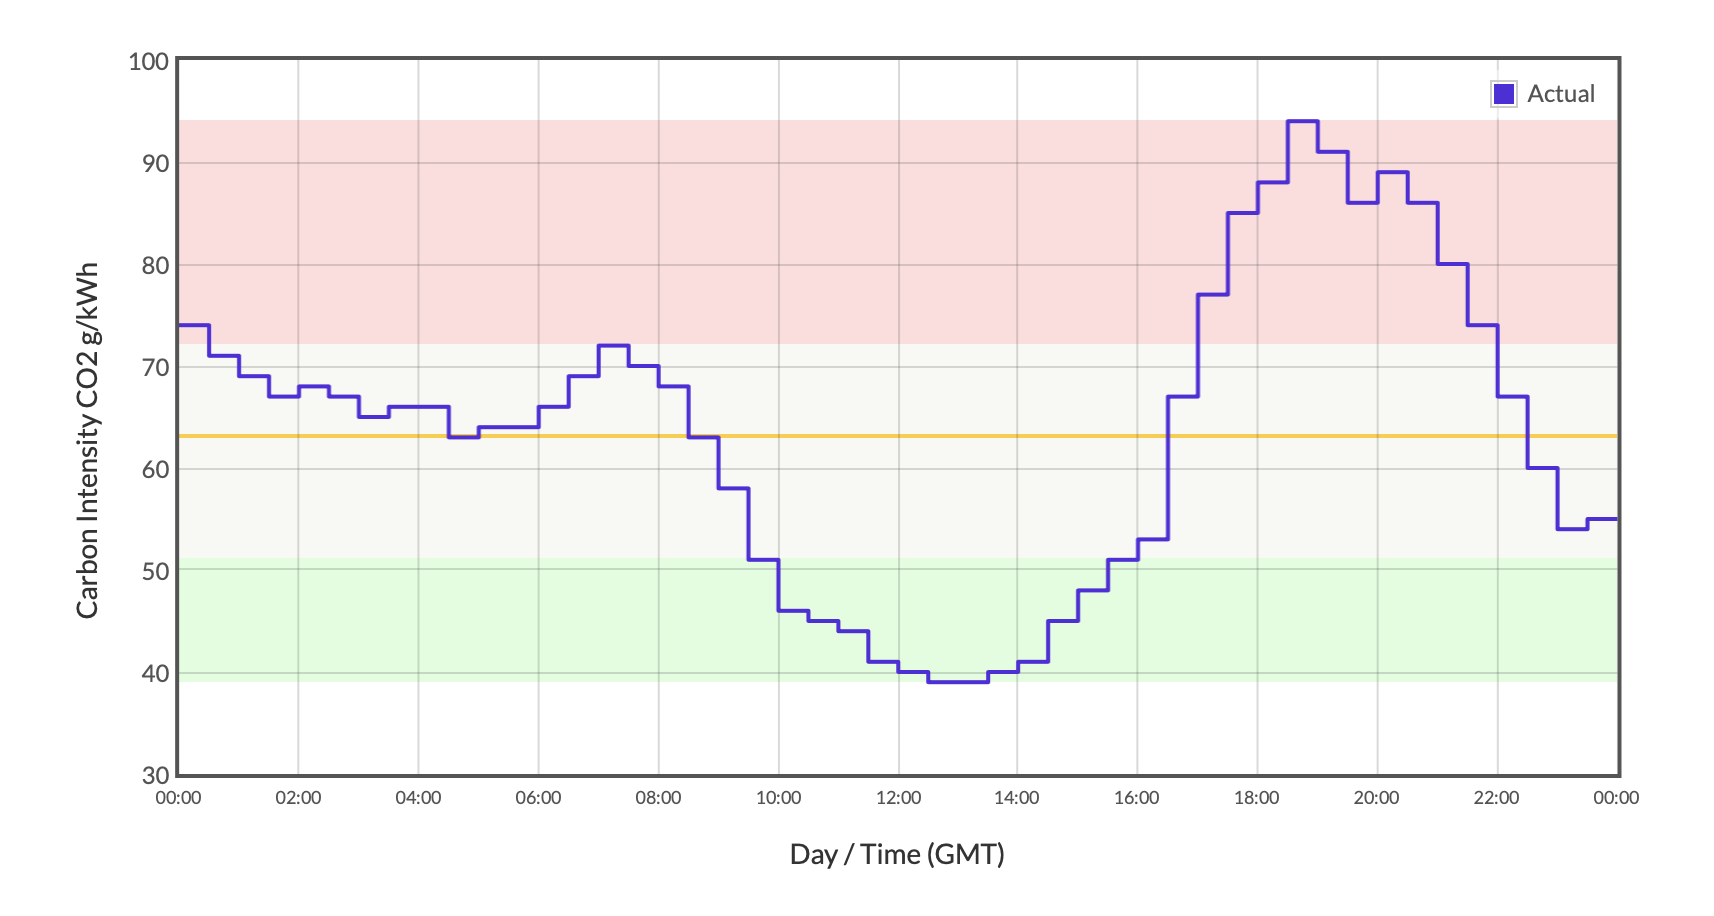

# How much curtailment was there on 19th March 2022?

In [50]:
df_fpn["delta"] = df_fpn["To Level"] - df_fpn["From Level"]

df_curtailed = df_fpn[df_fpn["delta"] < 0]

<IPython.core.display.Javascript object>

In [51]:
px.bar(
    df_curtailed,
    y="delta",
    color="Fuel Type",
)

<IPython.core.display.Javascript object>

# These are powers, let's go to energy


In [52]:
df_curtailed.head()
df_

,Notification Type,Settlement Period,From Time,From Level,To Time,To Level,Fuel Type,delta
2__ALOND000,PN,27,2022-03-19 13:00:00,-353.0,2022-03-19 13:30:00,-357.0,Unknown,-4.0
2__ASMAR000,PN,27,2022-03-19 13:00:00,38.0,2022-03-19 13:30:00,37.0,Unknown,-1.0
2__BLOND000,PN,27,2022-03-19 13:00:00,-151.0,2022-03-19 13:30:00,-152.0,Unknown,-1.0
2__BSMAR000,PN,27,2022-03-19 13:00:00,-55.0,2022-03-19 13:30:00,-61.0,Unknown,-6.0
2__DLOND000,PN,27,2022-03-19 13:00:00,-102.0,2022-03-19 13:30:00,-103.0,Unknown,-1.0


<IPython.core.display.Javascript object>

In [53]:
df_curtailed["time_delta"] = df_curtailed["To Time"] - df_curtailed["From Time"]

/var/folders/sf/4bylsrk971jbzjfzklc8jv7w0000gn/T/ipykernel_64682/2050122022.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>

In [54]:
px.histogram(df_curtailed, "time_delta")

<IPython.core.display.Javascript object>

I think we can just multiply through by these

In [62]:
df_curtailed["energy (mwh)"] = (
    df_curtailed["time_delta"].apply(lambda x: x.total_seconds() / 3_600)
    * -df_curtailed["delta"]
)

/var/folders/sf/4bylsrk971jbzjfzklc8jv7w0000gn/T/ipykernel_64682/3002431025.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>

In [63]:
px.histogram(df_curtailed, "energy (mwh)")

<IPython.core.display.Javascript object>

In [64]:
df_curtailed.head()

,Notification Type,Settlement Period,From Time,From Level,To Time,To Level,Fuel Type,delta,time_delta,energy (mwh)
2__ALOND000,PN,27,2022-03-19 13:00:00,-353.0,2022-03-19 13:30:00,-357.0,Unknown,-4.0,0 days 00:30:00,2.0
2__ASMAR000,PN,27,2022-03-19 13:00:00,38.0,2022-03-19 13:30:00,37.0,Unknown,-1.0,0 days 00:30:00,0.5
2__BLOND000,PN,27,2022-03-19 13:00:00,-151.0,2022-03-19 13:30:00,-152.0,Unknown,-1.0,0 days 00:30:00,0.5
2__BSMAR000,PN,27,2022-03-19 13:00:00,-55.0,2022-03-19 13:30:00,-61.0,Unknown,-6.0,0 days 00:30:00,3.0
2__DLOND000,PN,27,2022-03-19 13:00:00,-102.0,2022-03-19 13:30:00,-103.0,Unknown,-1.0,0 days 00:30:00,0.5


<IPython.core.display.Javascript object>

In [65]:
by_fuel = df_curtailed.groupby("Fuel Type").sum().reset_index()

px.bar(by_fuel, x="energy (mwh)", y="Fuel Type")

<IPython.core.display.Javascript object>

In this settlement period, we curtailed 50 MWh of wind power

How does this compare to total generation in this period?

In [70]:
start_date = "2022-03-19"
end_date = "2022-03-20"


df_B1610 = client.get_B1610(start_date, end_date)

B1610: 100%|██████████| 48/48 [00:58<00:00,  1.22s/it]


<IPython.core.display.Javascript object>

In [75]:
df_B1620 = client.get_B1620(start_date, end_date)

B1620: 100%|██████████| 48/48 [00:15<00:00,  3.05it/s]


NameError: name 'df' is not defined

<IPython.core.display.Javascript object>

In [91]:
df_B1620["quantity"] = df_B1620["quantity"].astype(float)
df_B1620["settlementPeriod"] = df_B1620["settlementPeriod"].astype(int)

<IPython.core.display.Javascript object>

In [86]:
df_B1620.head()

,local_datetime,documentType,businessType,processType,timeSeriesID,quantity,curveType,resolution,settlementDate,settlementPeriod,powerSystemResourceType,activeFlag,documentID,documentRevNum
0,2022-03-19 00:00:00+00:00,Actual generation per type,Solar generation,Realised,NGET-EMFIP-AGPT-TS-21944960,1.000,Sequential fixed size block,PT30M,2022-03-19,1,"""Solar""",Y,NGET-EMFIP-AGPT-06402555,1
1,2022-03-19 00:00:00+00:00,Actual generation per type,Wind generation,Realised,NGET-EMFIP-AGPT-TS-21944961,4963.873,Sequential fixed size block,PT30M,2022-03-19,1,"""Wind Offshore""",Y,NGET-EMFIP-AGPT-06402555,1
2,2022-03-19 00:00:00+00:00,Actual generation per type,Wind generation,Realised,NGET-EMFIP-AGPT-TS-21944962,4400.863,Sequential fixed size block,PT30M,2022-03-19,1,"""Wind Onshore""",Y,NGET-EMFIP-AGPT-06402555,1
3,2022-03-19 00:00:00+00:00,Actual generation per type,Production,Realised,NGET-EMFIP-AGPT-TS-21944963,164.000,Sequential fixed size block,PT30M,2022-03-19,1,"""Other""",Y,NGET-EMFIP-AGPT-06402555,1
4,2022-03-19 00:00:00+00:00,Actual generation per type,Production,Realised,NGET-EMFIP-AGPT-TS-21944964,5814.000,Sequential fixed size block,PT30M,2022-03-19,1,"""Nuclear""",Y,NGET-EMFIP-AGPT-06402555,1


<IPython.core.display.Javascript object>

In [92]:
generation_by_fuel = (
    df_B1620.groupby(["local_datetime", "businessType", "settlementPeriod"])
    .sum()
    .reset_index()
)
px.line(generation_by_fuel, "local_datetime", "quantity", color="businessType")

<IPython.core.display.Javascript object>

In [96]:
generation_by_fuel["mwh"] = generation_by_fuel["quantity"] * 0.5
sp_27 = generation_by_fuel[generation_by_fuel["settlementPeriod"] == 27]
px.bar(sp_27, x="businessType", y="mwh")

<IPython.core.display.Javascript object>

In [103]:
100 * by_fuel.set_index("Fuel Type").loc["WIND", "energy (mwh)"] / sp_27.set_index(
    "businessType"
).loc["Wind generation", "mwh"]

0.8657494563791139

<IPython.core.display.Javascript object>

It looks like less than 1% of wind power was curtailed, in the most curtailed settlement period of the year... this doesn't seem quite right